# import libreries for the experiment

In [1]:
import sys
import os
import json
import random 

import numpy as np                                                                  
import pandas as pd
import matplotlib.pyplot as plt                                                       

import cv2                                                                         
import mediapipe as mp  

from glob import glob                                                               
from pathlib import Path                                                            
from natsort import natsorted                                                       
from tqdm.auto import tqdm 

from sklearn.model_selection import train_test_split                                                
from collections import defaultdict
from typing import Callable, List, Tuple
from numpy.typing import NDArray

import torch
from torch import nn
import torch.optim as optim                                                          
import torch.nn.functional as F 
import seaborn as sns
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter 
from torchinfo import summary
    
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from captum.attr import LayerConductance

In [2]:
sys.path.append(os.path.abspath('../src'))
import prepare_datasets
import preprocessing 
import models  
import training 
import plotting
import set_train
import analyse_layer

# Getting landmarks from LSA 64 dataset

In [3]:
# define directories
# root= 'C:/Users/sadeg/OneDrive/Desktop/Thesis/python_codes/lsa64_raw/all'
# save_dir= 'C:/Users/sadeg/OneDrive/Desktop/Thesis/python_codes/SignLanguageProject/data/landmarks_lsa64'

# 30fps
# get media pipe landmarks
#result= prepare_datasets.get_landmarks_LSA64(root, prepare_datasets.lsa64class_names, 30)

#save media pipe landmarks
#np.save(os.path.join(save_dir, 'detections30fps.npy'), np.array(result[0]))     
#with open(os.path.join(save_dir, 'labels30fps.json'), 'w') as file:
    #json.dump(result[1], file) 

# 40fps
# get media pipe landmarks
#result= prepare_datasets.get_landmarks_LSA64(root, prepare_datasets.lsa64class_names, 40)

#save media pipe landmarks
#np.save(os.path.join(save_dir, 'detections40fps.npy'), np.array(result[0]))     
#with open(os.path.join(save_dir, 'labels40fps.json'), 'w') as file:
    #json.dump(result[1], file) 

# 50fps
# get media pipe landmarks
#result= prepare_datasets.get_landmarks_LSA64(root, prepare_datasets.lsa64class_names, 50)

#save media pipe landmarks
#np.save(os.path.join(save_dir, 'detections50fps.npy'), np.array(result[0]))     
#with open(os.path.join(save_dir, 'labels50fps.json'), 'w') as file:
    #json.dump(result[1], file)

# 60fps
# get media pipe landmarks
#result= prepare_datasets.get_landmarks_LSA64(root, prepare_datasets.lsa64class_names, 60)

#save media pipe landmarks
#np.save(os.path.join(save_dir, 'detections60fps.npy'), np.array(result[0]))     
#with open(os.path.join(save_dir, 'labels60fps.json'), 'w') as file:
    #json.dump(result[1], file)

# loading all saved landmarks from LSA 64 dataset

In [4]:
# defining path to project folder
root_dir= os.path.dirname(os.getcwd())

# path to dataset directories
data_dir= os.path.join(root_dir, 'data')

# path to LSA 64 landmark directory
lsa= os.path.join(data_dir, 'landmarks_lsa64')

# dictionaries to categorize labels and detections based on the fps
lsa64_labels = {'30fps': None, '40fps': None, '50fps': None, '60fps': None}
lsa64 = {'30fps': None, '40fps': None, '50fps': None, '60fps': None}

# loading detections and labels to the dictionaries
for i in [30, 40, 50, 60]:
    lsa64[f'{i}fps']= np.load(os.path.join(lsa, f'detections{i}fps.npy'), allow_pickle=True)
    with open(os.path.join(lsa, f'labels{i}fps.json'), 'r') as file:
        lsa64_labels[f'{i}fps']= json.load(file)

In [5]:
lsa64['30fps'].shape, lsa64['40fps'].shape, lsa64['50fps'].shape, lsa64['60fps'].shape

((3200, 30, 1662), (3200, 40, 1662), (3200, 50, 1662), (3200, 60, 1662))

In [6]:
len(lsa64_labels['30fps']), len(lsa64_labels['40fps']), len(lsa64_labels['40fps']), len(lsa64_labels['60fps'])

(3200, 3200, 3200, 3200)

# visualizing how interpolation works

In [8]:
video1= lsa64['30fps'][0]
video2= lsa64['30fps'][48]
ivd= preprocessing.interpolate_video_detections(video1, video2, [(0, 132), (132, 1536), (1536, 1599), (1599, 1662)], 0.5)
video1.shape, video2.shape, ivd.shape

((30, 1662), (30, 1662), (30, 1662))

In [9]:
plotting.show_detections(ivd)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  #set up device to cuda
print(device)
print(torch.cuda.get_device_name())
print(torch.cuda.get_device_capability())

cuda
NVIDIA GeForce RTX 3060 Laptop GPU
(8, 6)


# Layer analyse experiment

untrained model

1. show layer attributes

Input shape: torch.Size([1, 30, 1662])
Target label: [17]


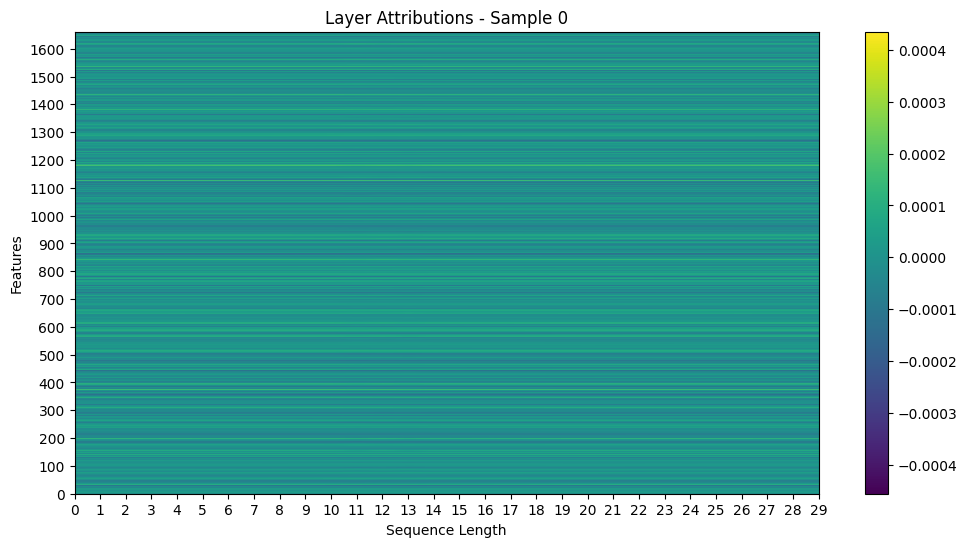

In [14]:
model= models.Transformer(prepare_datasets.lsa64class_names,30)

model.eval()
model.to(device)

X, y= preprocessing.convert(lsa64['30fps'], lsa64_labels['30fps'], prepare_datasets.lsa64class_names)

dataset= preprocessing.CustomDataset(X, y)
dataloader= DataLoader(dataset=dataset, batch_size= 1, num_workers=0, shuffle=True) 

input, target = next(iter(dataloader))
input, target = input.to(device), target.to(device)

print("Input shape:", input.shape) 
print("Target label:", target.tolist())  

layer_cond = LayerConductance(model, model.transformer_encoder.layers[0])
attributions = layer_cond.attribute(input, target=target.tolist())


analyse_layer.plot_atts_heatmap(attributions, title="Layer Attributions")

2. visualize attributes in sample video

In [15]:
video_path= 'C:/Users/sadeg/OneDrive/Desktop/Thesis/python_codes/lsa64_raw/all/048_002_001.mp4'
results, pixel_coor, video_detections, label= analyse_layer.get_landmarks(video_path)
len(results), len(pixel_coor), len(video_detections), label

(30, 30, 30, 47)

In [16]:
X= torch.tensor(np.array(video_detections), dtype=torch.float32)       # making feature
X= X.unsqueeze(0)                                                      # adds batch dimention
X= X.to(device)

y= torch.tensor(label, dtype=torch.long)                               #making label
y= y.to(device)

In [17]:
model.eval()
with torch.no_grad():
    logits = model(X)
    predicton= torch.argmax(logits, 1)
    print(f'prediction: {predicton.tolist()}, label: {label}')

prediction: [1], label: 47


In [18]:
X.requires_grad = True
layer_cond = LayerConductance(model, model.transformer_encoder.layers[0])
attributions = layer_cond.attribute(X, target=y.tolist())

means = analyse_layer.calculate_means(attributions)
topk_values, topk_indices = torch.topk(means, 543, dim=2)

idx_trs= analyse_layer.make_idx_tr_pairs(topk_indices, means)

In [19]:
analyse_layer.draw_layer_attr(video_path, results, pixel_coor, idx_trs, 30, 10)

trained model

Training Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

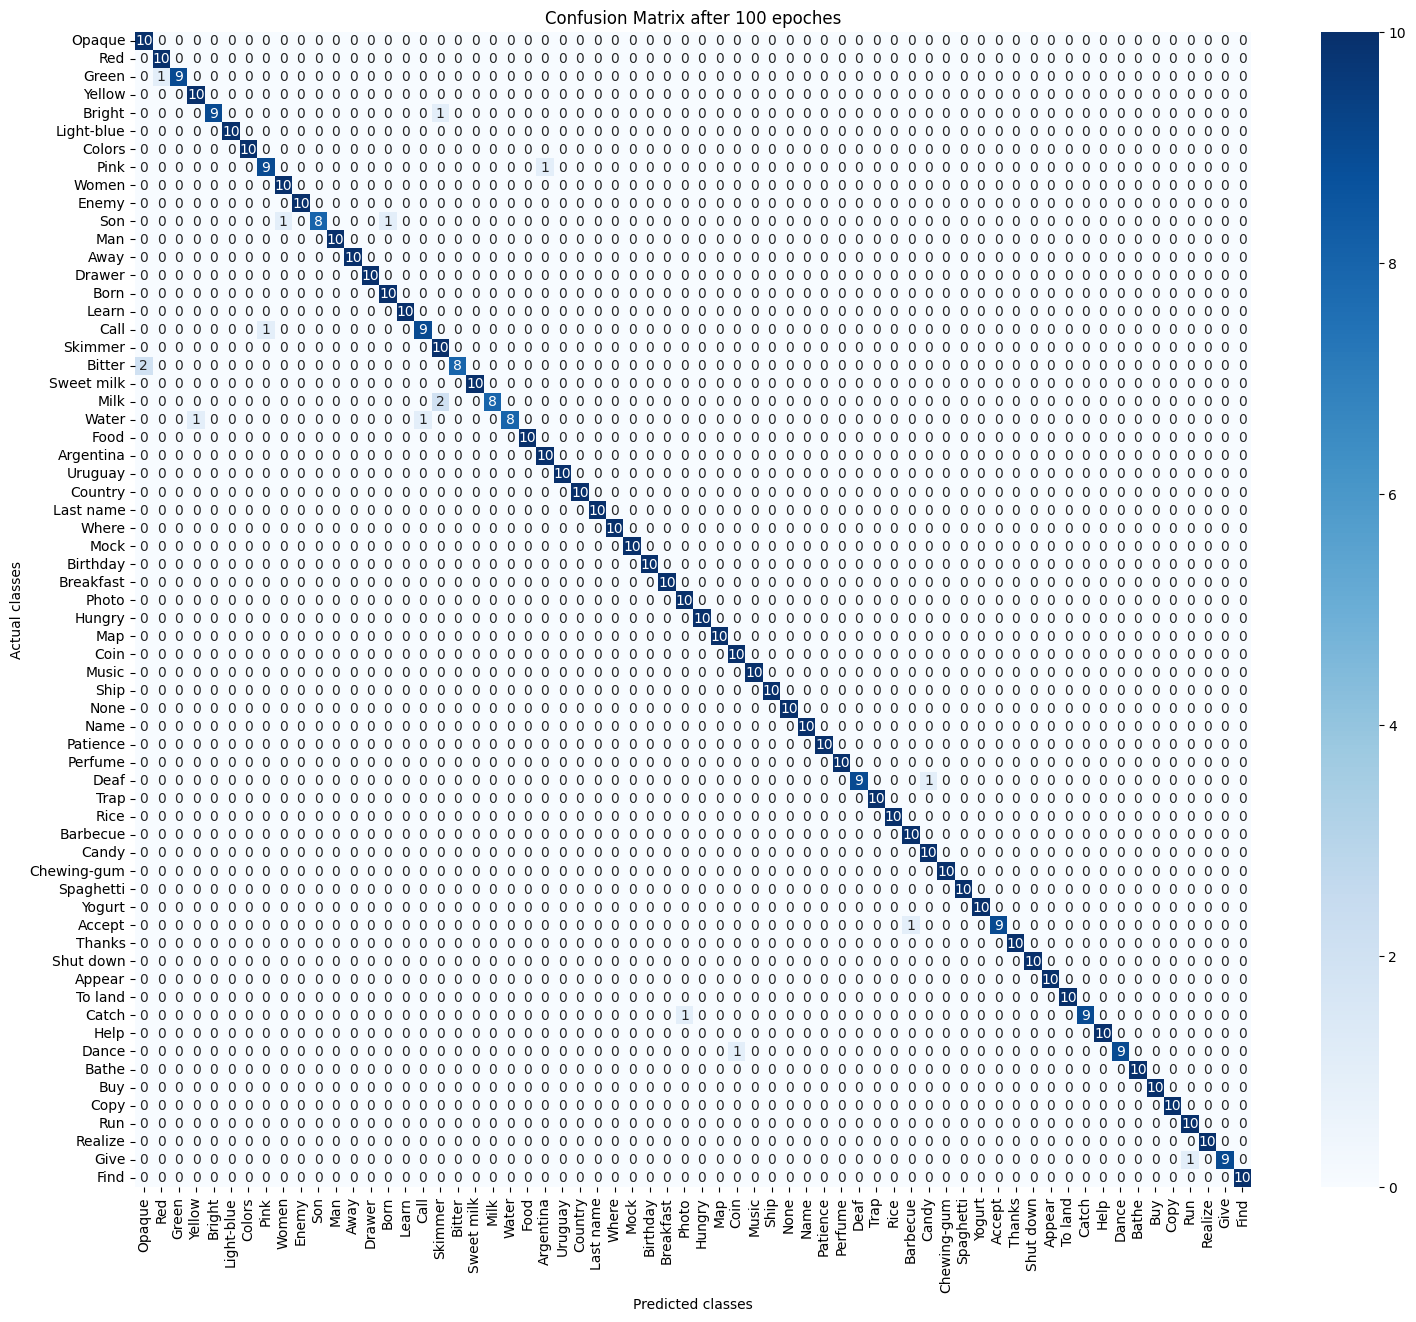

In [30]:
set_train.train_parameters(detections= lsa64['30fps'],
                           labels= lsa64_labels['30fps'],
                           class_names= prepare_datasets.lsa64class_names, 
                           test_size= 0.2, 
                           random_state= 42, 
                           batch_size= 128, 
                           num_epochs= 100,
                           model= model, 
                           learning_rate= 0.0001,
                           device= device,
                           dir= 'LSA64')

1. show layer attributes

In [ ]:
model.to('cpu')
torch.save(model.state_dict(),'transformer_model_state_dict.pth')

Input shape: torch.Size([1, 30, 1662])
Target label: [24]


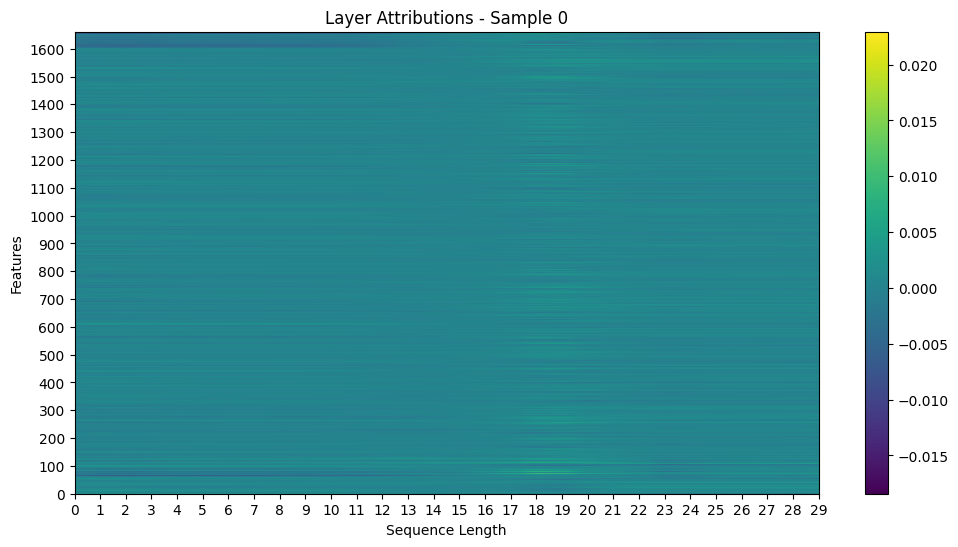

In [11]:
model= models.Transformer(prepare_datasets.lsa64class_names,30)
model.load_state_dict(torch.load('transformer_model_state_dict.pth', map_location= torch.device('cuda')))

model.eval()
model.to(device)

X, y= preprocessing.convert(lsa64['30fps'], lsa64_labels['30fps'], prepare_datasets.lsa64class_names)

dataset= preprocessing.CustomDataset(X, y)
dataloader= DataLoader(dataset=dataset, batch_size= 1, num_workers=0, shuffle=True) 

input, target = next(iter(dataloader))
input, target = input.to(device), target.to(device)

print("Input shape:", input.shape) 
print("Target label:", target.tolist())  

layer_cond = LayerConductance(model, model.transformer_encoder.layers[0])
attributions = layer_cond.attribute(input, target=target.tolist())


analyse_layer.plot_atts_heatmap(attributions, title="Layer Attributions")

In [12]:
video_path= 'C:/Users/sadeg/OneDrive/Desktop/Thesis/python_codes/lsa64_raw/all/001_007_002.mp4'
results, pixel_coor, video_detections, label= analyse_layer.get_landmarks(video_path)
len(results), len(pixel_coor), len(video_detections), label

(30, 30, 30, 0)

In [13]:
X= torch.tensor(np.array(video_detections), dtype=torch.float32)       # making feature
X= X.unsqueeze(0)                                                      # adds batch dimention
X= X.to(device)

y= torch.tensor(label, dtype=torch.long)                               #making label
y= y.to(device)

In [14]:
model.eval()
with torch.no_grad():
    logits = model(X)
    predicton= torch.argmax(logits, 1)
    print(f'prediction: {predicton.tolist()}, label: {label}')

prediction: [0], label: 0


In [15]:
X.requires_grad = True
layer_cond = LayerConductance(model, model.transformer_encoder.layers[0])
attributions = layer_cond.attribute(X, target=y.tolist())

means = analyse_layer.calculate_means(attributions)
topk_values, topk_indices = torch.topk(means, 543, dim=2)

idx_trs= analyse_layer.make_idx_tr_pairs(topk_indices, means)

# making input smaller?

In [8]:
pose_indices = np.arange(132)
lh_rh_indices = np.arange(1536, 1662)

# Concatenate indices to keep
indices_to_keep = np.concatenate((pose_indices, lh_rh_indices))

# Filter the data to remove face landmarks
filtered_data = lsa64['40fps'][:, :, indices_to_keep]

In [9]:
X, y= preprocessing.convert(filtered_data, lsa64_labels['40fps'], prepare_datasets.lsa64class_names) 
dataset= preprocessing.CustomDataset(X, y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [22]:
model= models.PETransformer(prepare_datasets.lsa64class_names, 40, 258)

In [24]:
from captum.attr import Saliency
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance

Input shape: torch.Size([1, 40, 258])
Target label: 2


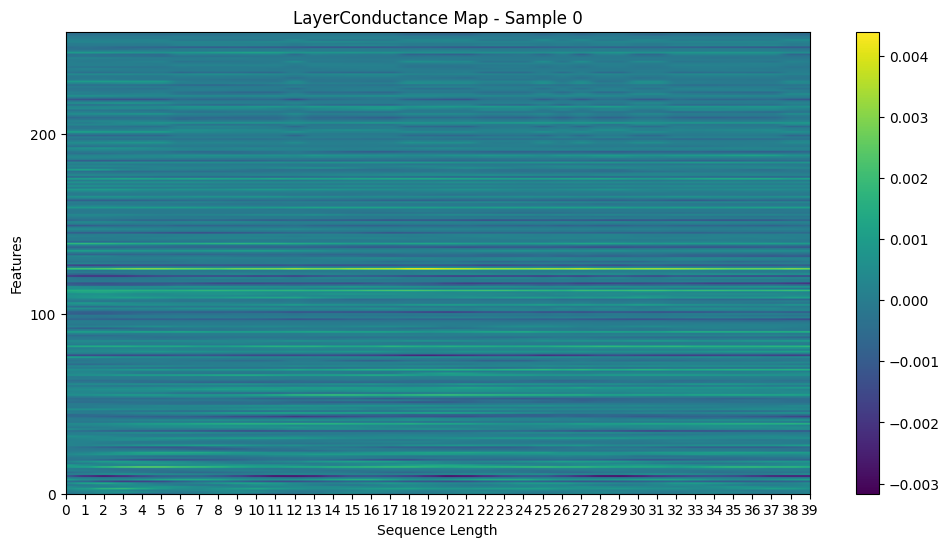

In [25]:
model.eval()
model.to(device)

# Load and prepare the dataset
X, y = preprocessing.convert(filtered_data, lsa64_labels['40fps'], prepare_datasets.lsa64class_names)
dataset = preprocessing.CustomDataset(X, y)

# Get a single batch from the dataloader
input, target = dataset[100]
input = input.unsqueeze(0)

input, target = input.to(device), target.to(device)

print("Input shape:", input.shape)
print("Target label:", target.tolist())

layer_cond = LayerConductance(model, model.transformer_encoder.layers[0])
attributions = layer_cond.attribute(input, target=target.tolist())

analyse_layer.plot_atts_heatmap(attributions, title="LayerConductance Map")

attributions_np = attributions.cpu().detach().numpy()  # Ensure it's on CPU and detached from the computation graph
np.save('LayerConductance_untrained.npy', attributions_np)

Input shape: torch.Size([1, 40, 258])
Target label: 2


C:\Users\sadeg\AppData\Local\Programs\Python\Python310\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


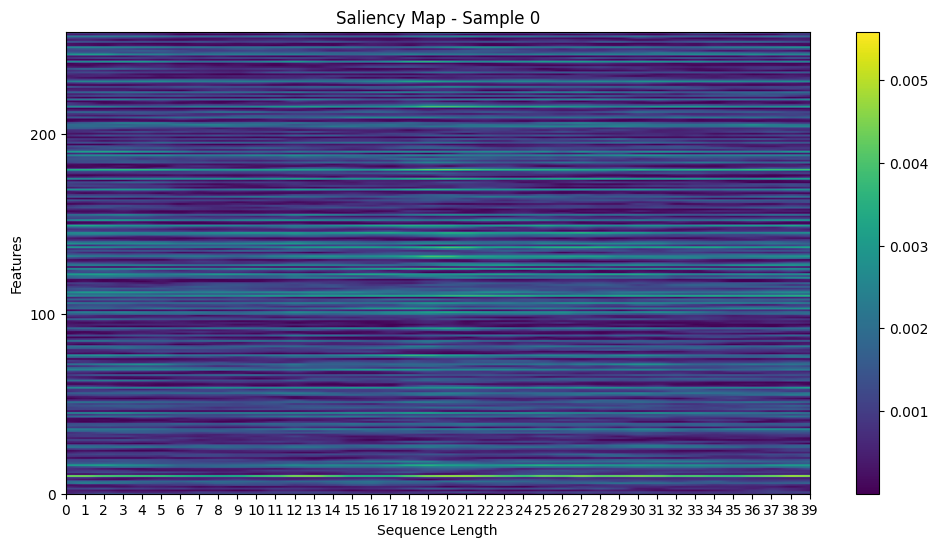

In [26]:
model.eval()
model.to(device)

# Load and prepare the dataset
X, y = preprocessing.convert(filtered_data, lsa64_labels['40fps'], prepare_datasets.lsa64class_names)
dataset = preprocessing.CustomDataset(X, y)

# Get a single batch from the dataloader
input, target = dataset[100]
input = input.unsqueeze(0)

input, target = input.to(device), target.to(device)

print("Input shape:", input.shape)
print("Target label:", target.tolist())

saliency = Saliency(model)
attributions = saliency.attribute(input, target=target.tolist())

analyse_layer.plot_atts_heatmap(attributions, title="Saliency Map")

attributions_np = attributions.cpu().detach().numpy()  # Ensure it's on CPU and detached from the computation graph
np.save('Saliency_untrained.npy', attributions_np)

Input shape: torch.Size([1, 40, 258])
Target label: 2


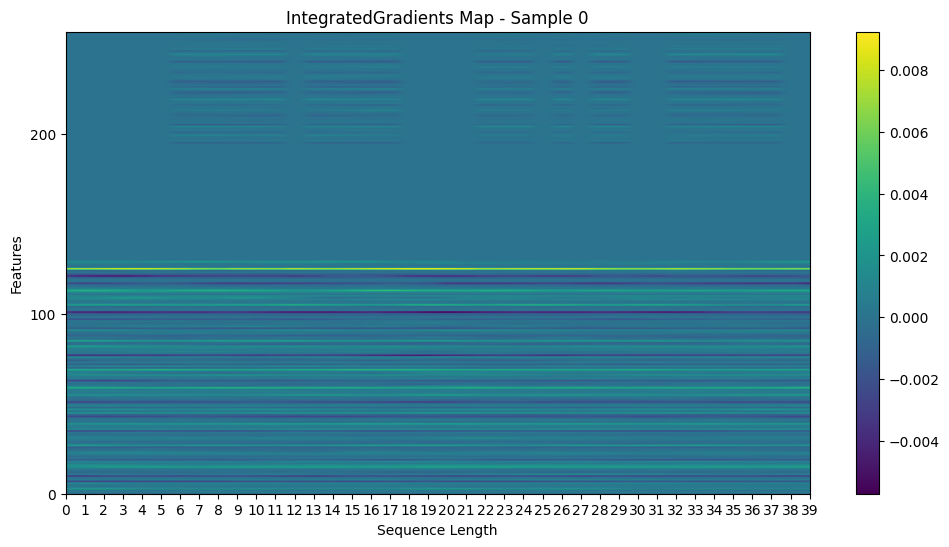

In [27]:
model.eval()
model.to(device)

# Load and prepare the dataset
X, y = preprocessing.convert(filtered_data, lsa64_labels['40fps'], prepare_datasets.lsa64class_names)
dataset = preprocessing.CustomDataset(X, y)

# Get a single batch from the dataloader
input, target = dataset[100]
input = input.unsqueeze(0)

input, target = input.to(device), target.to(device)
print("Input shape:", input.shape)
print("Target label:", target.tolist())

integrated_gradients = IntegratedGradients(model)
attributions = integrated_gradients.attribute(input, target=target.tolist())

analyse_layer.plot_atts_heatmap(attributions, title="IntegratedGradients Map")

attributions_np = attributions.cpu().detach().numpy()  # Ensure it's on CPU and detached from the computation graph
np.save('IntegratedGradients_untrained.npy', attributions_np)

Training Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

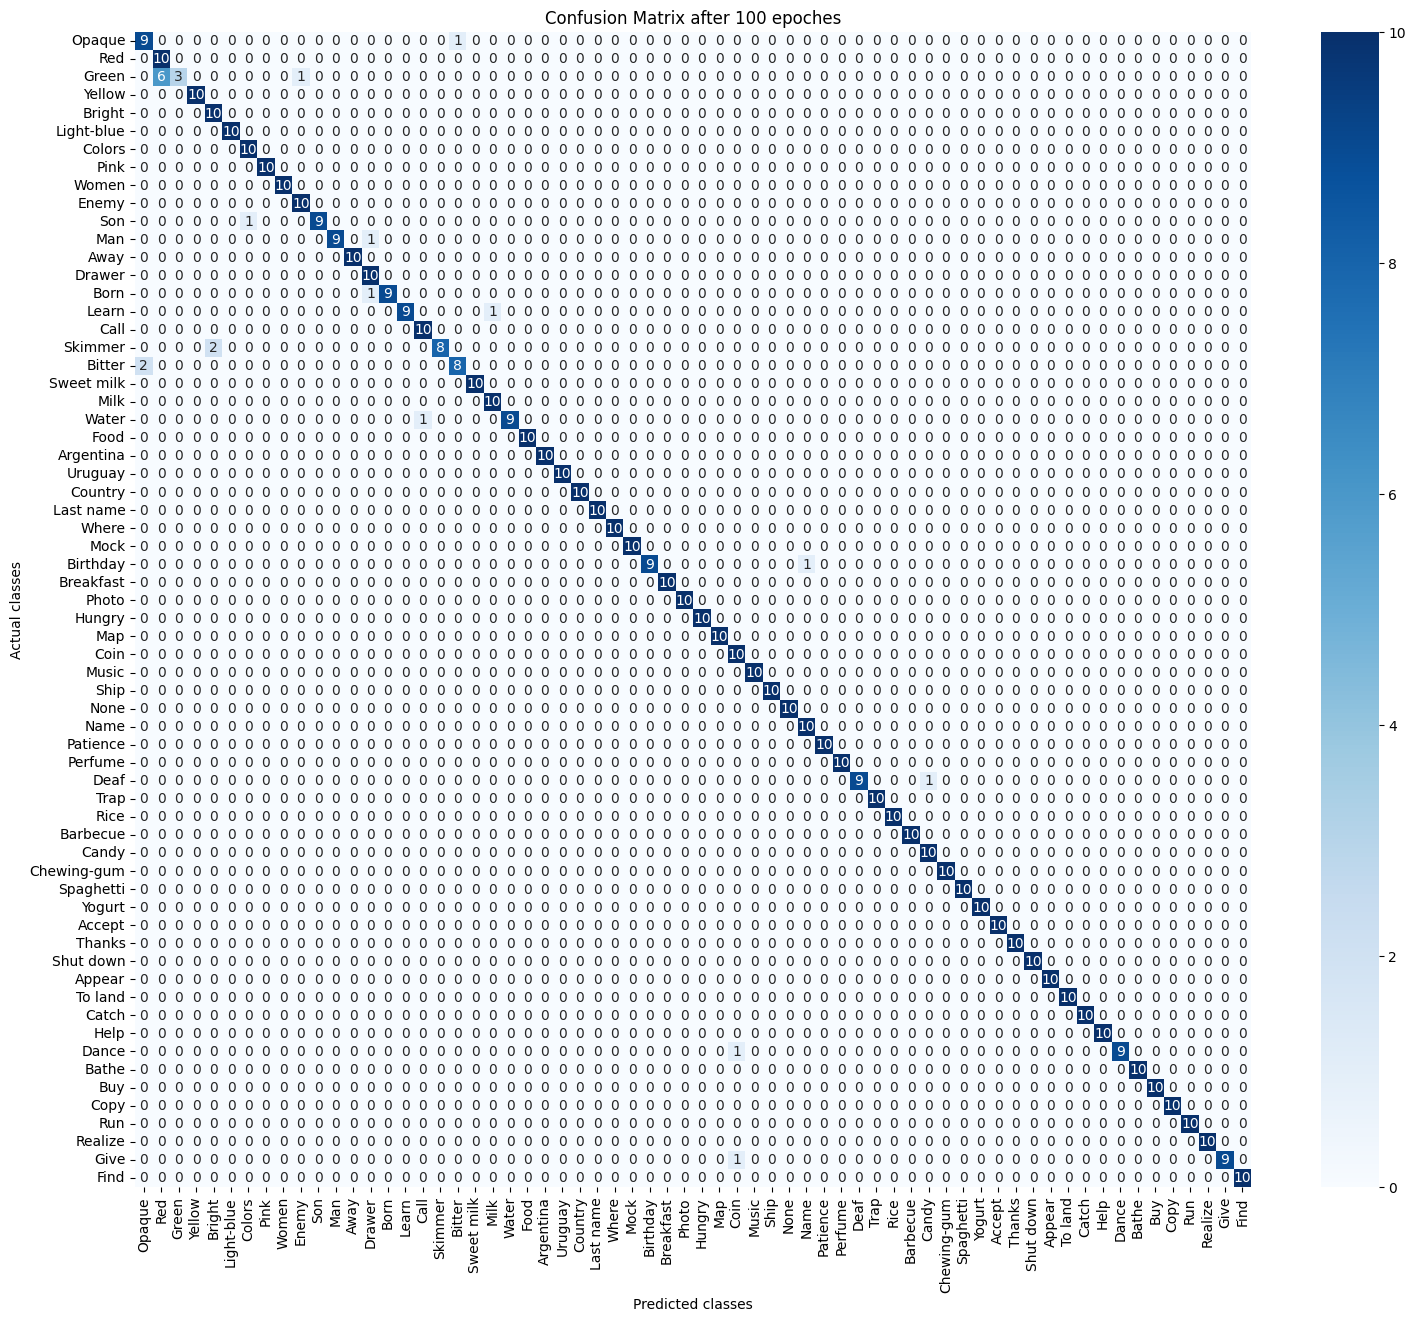

In [28]:
set_train.train_parameters(detections= filtered_data,
                           labels= lsa64_labels['40fps'],
                           class_names= prepare_datasets.lsa64class_names, 
                           test_size= 0.2, 
                           random_state= 42, 
                           batch_size= 128, 
                           num_epochs= 100,
                           model= model, 
                           learning_rate= 0.0001,
                           device= device,
                           dir= 'LSA64')

Input shape: torch.Size([1, 40, 258])
Target label: 2


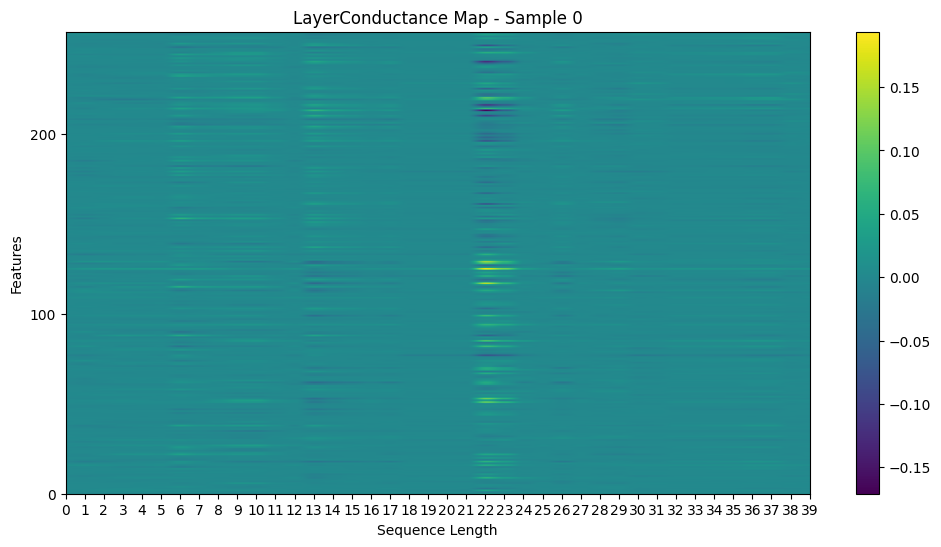

In [29]:
model.eval()
model.to(device)

# Load and prepare the dataset
X, y = preprocessing.convert(filtered_data, lsa64_labels['40fps'], prepare_datasets.lsa64class_names)
dataset = preprocessing.CustomDataset(X, y)

# Get a single batch from the dataloader
input, target = dataset[100]
input = input.unsqueeze(0)

input, target = input.to(device), target.to(device)
print("Input shape:", input.shape)
print("Target label:", target.tolist())

layer_cond = LayerConductance(model, model.transformer_encoder.layers[0])
attributions = layer_cond.attribute(input, target=target.tolist())

analyse_layer.plot_atts_heatmap(attributions, title="LayerConductance Map")

attributions_np = attributions.cpu().detach().numpy()  # Ensure it's on CPU and detached from the computation graph
np.save('LayerConductance_trained.npy', attributions_np)

Input shape: torch.Size([1, 40, 258])
Target label: 2


C:\Users\sadeg\AppData\Local\Programs\Python\Python310\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


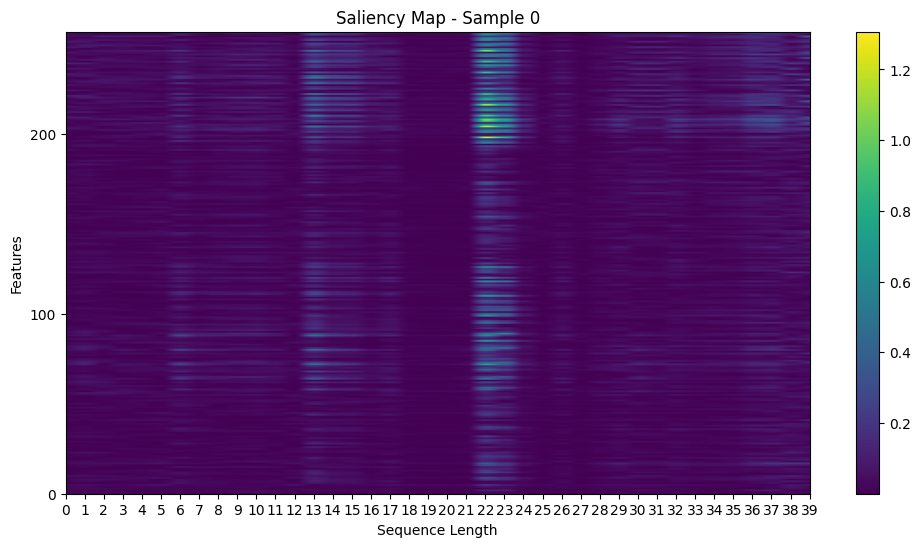

In [30]:
model.eval()
model.to(device)


# Load and prepare the dataset
X, y = preprocessing.convert(filtered_data, lsa64_labels['40fps'], prepare_datasets.lsa64class_names)
dataset = preprocessing.CustomDataset(X, y)
dataloader = DataLoader(dataset=dataset, batch_size=1, num_workers=0, shuffle=True)

# Get a single batch from the dataloader
input, target = dataset[100]
input = input.unsqueeze(0)

input, target = input.to(device), target.to(device)
print("Input shape:", input.shape)
print("Target label:", target.tolist())

saliency = Saliency(model)
attributions = saliency.attribute(input, target=target.tolist())

analyse_layer.plot_atts_heatmap(attributions, title="Saliency Map")

attributions_np = attributions.cpu().detach().numpy()  # Ensure it's on CPU and detached from the computation graph
np.save('Saliency_trained.npy', attributions_np)

Input shape: torch.Size([1, 40, 258])
Target label: 2


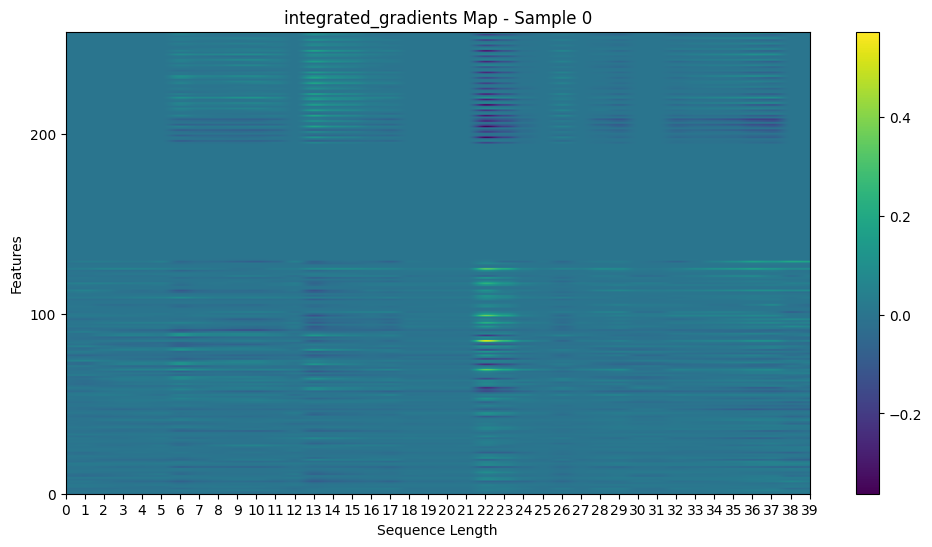

In [31]:
model.eval()
model.to(device)

# Load and prepare the dataset
X, y = preprocessing.convert(filtered_data, lsa64_labels['40fps'], prepare_datasets.lsa64class_names)
dataset = preprocessing.CustomDataset(X, y)
dataloader = DataLoader(dataset=dataset, batch_size=1, num_workers=0, shuffle=True)

# Get a single batch from the dataloader
input, target = dataset[100]
input = input.unsqueeze(0)

input, target = input.to(device), target.to(device)
print("Input shape:", input.shape)
print("Target label:", target.tolist())

integrated_gradients = IntegratedGradients(model)
attributions = integrated_gradients.attribute(input, target=target.tolist())

analyse_layer.plot_atts_heatmap(attributions, title="integrated_gradients Map")

attributions_np = attributions.cpu().detach().numpy()  # Ensure it's on CPU and detached from the computation graph
np.save('integrated_gradients_trained.npy', attributions_np)